# 1. Data processing
---

### Step 1: Load the dataset

In [50]:
#LIBRARIES
import pandas as pd
import regex as re

# Datset
total_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

total_data.head(5)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


***1.1. Transform category to number***

In [51]:
# Transform the category to 1 if true or 0 if false
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [52]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.is_spam == 1])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


The transformation was successful. Approximately 23% of the dataset is spam (1), and 77% is not spam (0)

### Step 2. Preprocess the links

***2.1. Define cleaning function***

In [53]:
def preprocess_text(text):
    # Remove https and www protocols
    text = re.sub(r'https?://(www\.)?', '', text)
    # Remove any character that is not a letter, number or '/'
    text = re.sub(r'[^0-9a-zA-Z./]', '', text)
    # Split text using '.' or '/' as marks
    text = re.split(r'\.|/',text)
    # Removing the white spaces
    text = list(filter(None, text))
    return text

In [54]:
# Appling function to the dataset
total_data['url'] = total_data['url'].apply(preprocess_text)
# Dataset preview
total_data.head(3)

,url,is_spam
0,"[briefingday, us8, listmanage, com, unsubscribe]",1
1,"[hvper, com]",1
2,"[briefingday, com, m, v4n3i4f3]",1


***2.2. Lemmatize the words***

In [55]:
# Import nltk libraries 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Download stopwords
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

# lemmatize function
def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Francesc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Francesc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
# Apply the function
total_data["url"] = total_data["url"].apply(lemmatize_text)
total_data.head(5)

,url,is_spam
0,"[briefingday, listmanage, unsubscribe]",1
1,[hvper],1
2,"[briefingday, v4n3i4f3]",1
3,"[briefingday, 20200618, mcommentform]",0
4,[briefingday],1


***2.3. plot words***

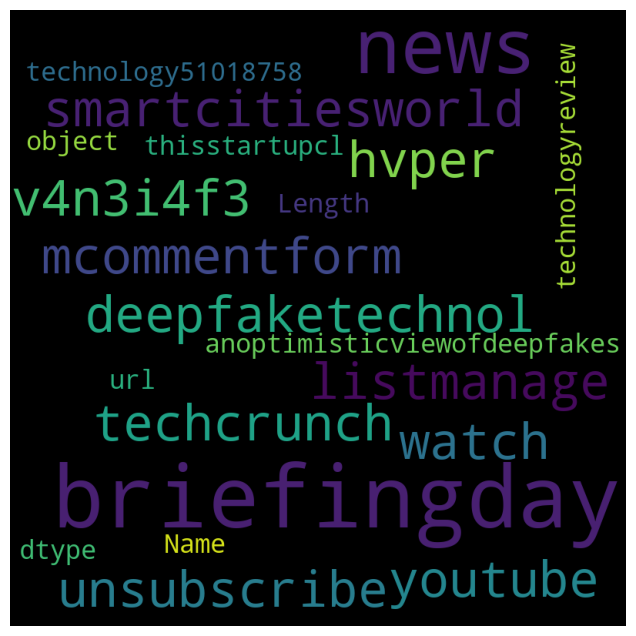

In [57]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Config plot
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

***2.4. Turn the words into vectors TF-IDF***

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
y[:5]

0    1
1    1
2    1
3    0
4    1
Name: is_spam, dtype: int32

***2.5. Make train / test division***

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [69]:
# Save datasets
train_data = pd.DataFrame({'features': X_train.tolist(), 'outcome': y_train})
test_data = pd.DataFrame({'features': X_test.tolist(), 'outcome': y_test})

train_data.to_csv('../data/processed/train_data.csv',index=False)
test_data.to_csv('../data/processed/test_data.csv',index=False)